In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [110]:
# historische Daten aus our_world_in_data
# https://ourworldindata.org/electric-car-sales 
hist_N_df = pd.read_excel(r"/Users/morteza/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/Dokumente/2. WiIng/3. Semester WS25-26/EE/Group Project/Our_world_in_data.xlsx", sheet_name="N_hist_total", header=0, index_col=0)
hist_n_df = pd.read_excel(r"/Users/morteza/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/Dokumente/2. WiIng/3. Semester WS25-26/EE/Group Project/Our_world_in_data.xlsx", sheet_name="n_hist_yearly", header=0, index_col=0)
hist_n_df

,Electric cars sold
Year,
2010,1440
2011,5120
2012,9860
2013,15730
2014,73000
2015,211000
2016,339000
2017,580000
2018,1090000


In [106]:
def _simulate_bass(p, q, m, T=30, dt=1.0, N0=0.0):
    """Simuliert Bass (Euler diskret). Gibt t, N(t), n(t) zurück."""
    if p < 0 or q < 0 or m <= 0:
        raise ValueError("Require p >= 0, q >= 0, and m > 0.")
    if N0 < 0 or N0 > m:
        raise ValueError("Require 0 <= N0 <= m.")
    if T <= 0 or dt <= 0:
        raise ValueError("Require T > 0 and dt > 0.")

    steps = int(np.ceil(T / dt)) + 1
    t = np.linspace(0, T, steps)

    N = np.zeros_like(t)
    n = np.zeros_like(t)
    N[0] = N0

    for i in range(1, len(t)):
        adoption_rate = (p + q * (N[i-1] / m)) * (m - N[i-1])
        dN = adoption_rate * dt
        N[i] = min(m, N[i-1] + dN)   # Overshoot verhindern
        n[i] = N[i] - N[i-1]
    
    # DataFrame
    df = pd.DataFrame({
        "t": t,
        "N": N,
        "n": n
    })

    return df

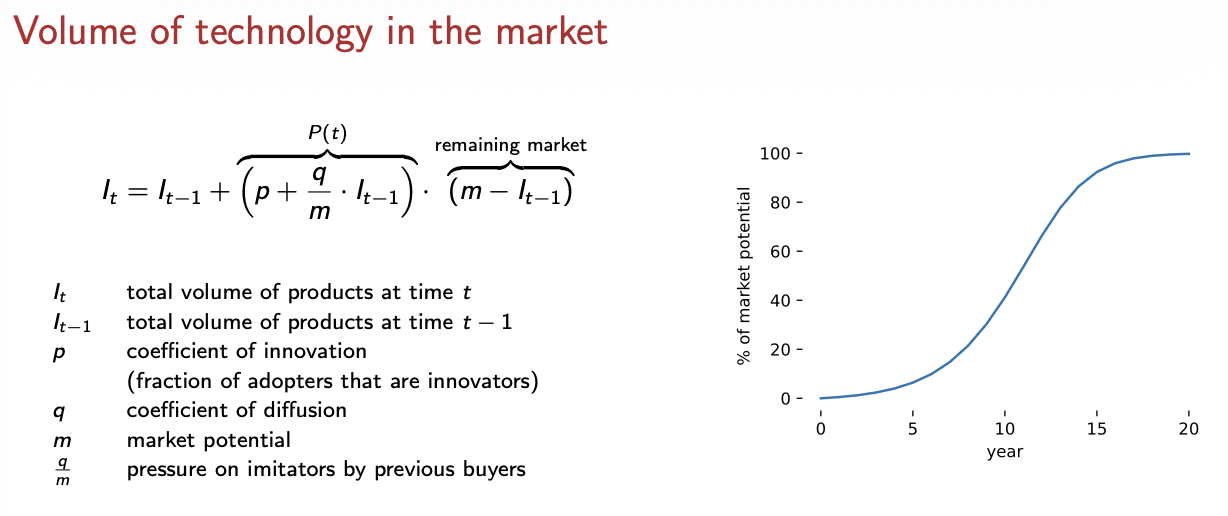

In [107]:
def bass_sensitivity(
    m,
    scenarios,
    T=30,
    dt=1.0,
    N0=0.0,
    start_year=0,
    title="Bass Diffusion Sensitivity",
    historisch=True
):
    """
    Sensitivity Analysis: mehrere (p,q)-Szenarien, zwei Plots (kumulativ & Zuwachs).
    Erwartet: _simulate_bass(...) gibt einen DataFrame mit Spalten t, N, n zurück.

    historisch = True : die historische Daten werden auch als Balken angezeigt
    """

    if not isinstance(scenarios, (list, tuple)) or len(scenarios) == 0:
        raise ValueError("scenarios must be a non-empty list of dicts with keys 'p' and 'q'.")

    # start_year robust (0, int, "2010", etc.)
    if start_year in (None, ""):
        start_year = 0
    if isinstance(start_year, str):
        start_year = int(start_year)

    results = []
    for s in scenarios:
        if "p" not in s or "q" not in s:
            raise ValueError("Each scenario dict must contain keys 'p' and 'q'.")
        p, q = float(s["p"]), float(s["q"])
        label = s.get("label", f"p={p:.4g}, q={q:.4g}")

        df = _simulate_bass(p=p, q=q, m=m, T=T, dt=dt, N0=N0)  # <-- DataFrame
        results.append((label, p, q, df))

    # x-Achse aus erstem DF (alle haben gleiche t-Gitter)
    t = results[0][3]["t"].to_numpy()
    x = t + start_year if start_year else t
    xlab = "Year" if start_year else "Time"

    fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)
    ax1, ax2 = axes


    # Historische Balken (oben: N)
    # Bars etwas transparent, damit Linien sichtbar bleiben
    if historisch == True:
        ax1.bar(hist_N_df.index, hist_N_df["Electric car stocks"].divide(1e6), width=0.8, alpha=0.35, label="Historical N", color="red")

    # oben: kumulativ
    for (label, p, q, df) in results:
        ax1.plot(x, df["N"].divide(1e6).to_numpy(), label=label)
    ax1.set_title(f"{title} — Cumulative Adoption")
    ax1.set_ylabel("Cumulative adopters N(t) in Millions")
    ax1.grid(True)
    ax1.legend()



    # Historische Balken (unten: n)
    if historisch == True:
        ax2.bar(hist_n_df.index, hist_n_df["Electric cars sold"].divide(1e6), width=0.8, alpha=0.35, label="Historical n", color="red")

    # unten: Zuwachs pro Zeitschritt
    step_name = "year" if dt == 1.0 else "step"
    for (label, p, q, df) in results:
        ax2.plot(x, df["n"].divide(1e6).to_numpy(), label=label)
    ax2.set_title(f"{title} — New Adopters per {step_name}")
    ax2.set_xlabel(xlab)
    ax2.set_ylabel(f"New adopters n(t) per {step_name} (Millions)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return results

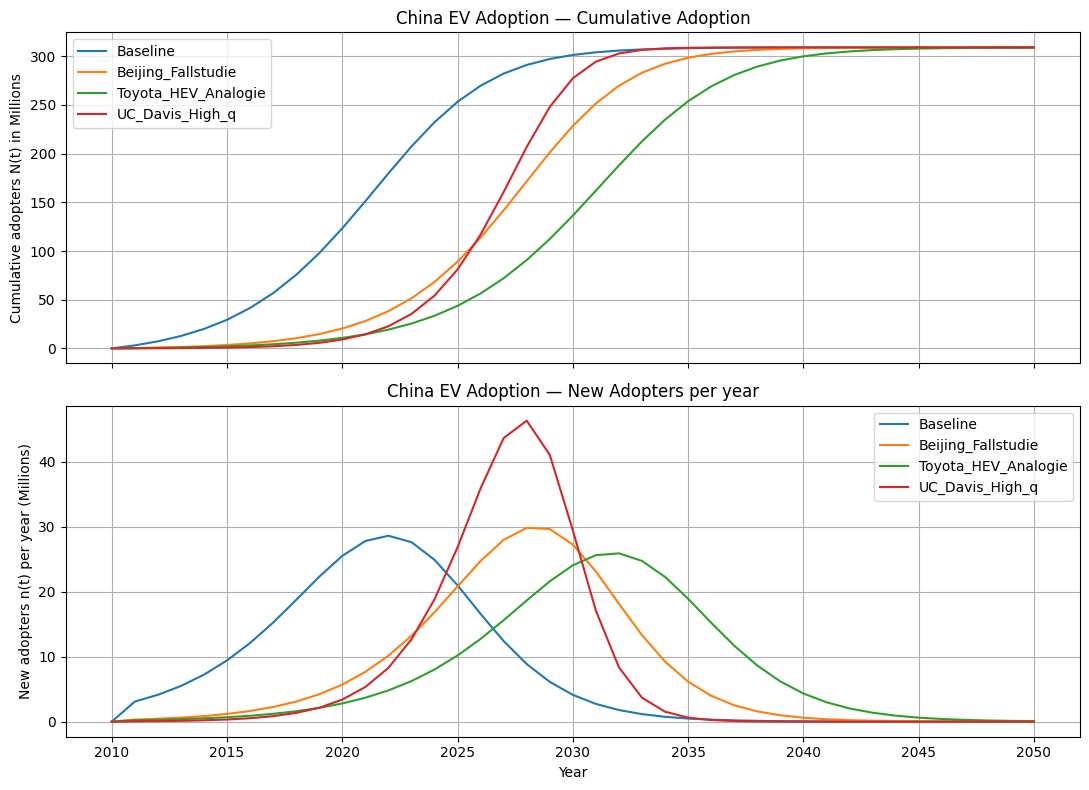

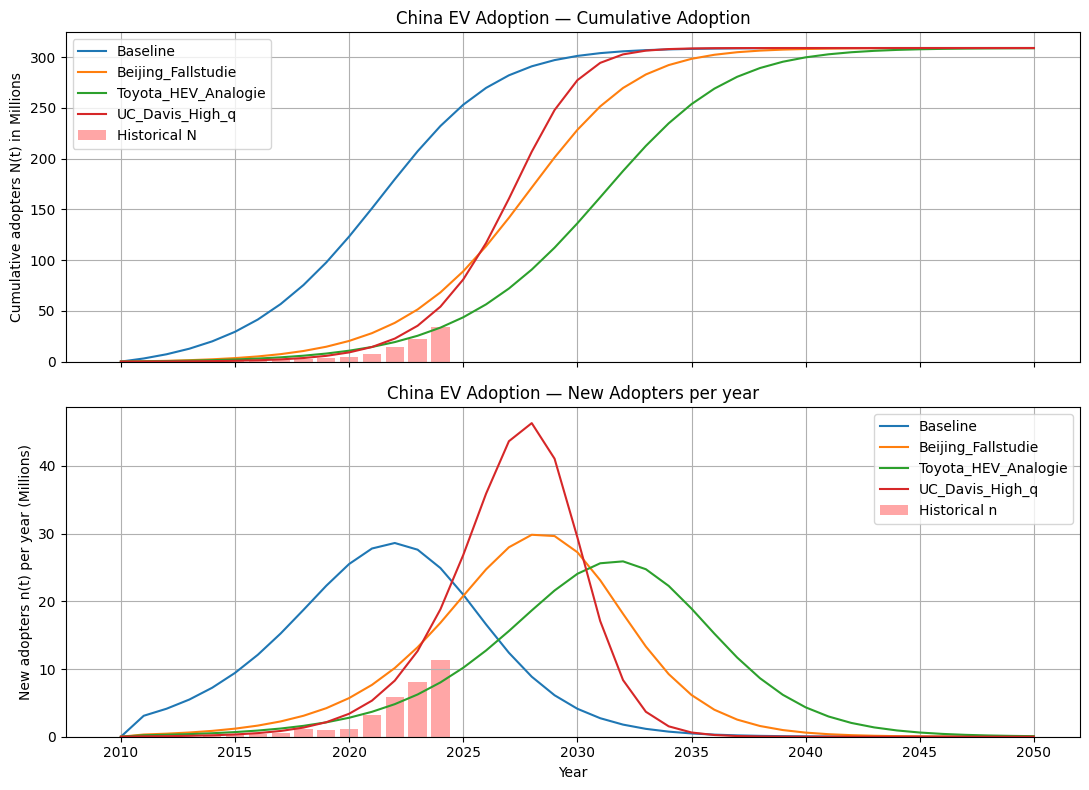

[('Baseline',
  0.01,
  0.35,
         t             N             n
  0    0.0  7.450000e+03  0.000000e+00
  1    1.0  3.100892e+06  3.093442e+06
  2    2.0  7.235216e+06  4.134324e+06
  3    3.0  1.272682e+07  5.491606e+06
  4    4.0  1.996144e+07  7.234619e+06
  5    5.0  2.938804e+07  9.426603e+06
  6    6.0  4.149292e+07  1.210488e+07
  7    7.0  5.674190e+07  1.524897e+07
  8    8.0  7.547928e+07  1.873738e+07
  9    9.0  9.778199e+07  2.230271e+07
  10  10.0  1.232920e+08  2.551000e+07
  11  11.0  1.510894e+08  2.779739e+07
  12  12.0  1.797013e+08  2.861194e+07
  13  13.0  2.073241e+08  2.762278e+07
  14  14.0  2.322330e+08  2.490886e+07
  15  15.0  2.532128e+08  2.097989e+07
  16  16.0  2.697933e+08  1.658049e+07
  17  17.0  2.821918e+08  1.239843e+07
  18  18.0  2.910561e+08  8.864360e+06
  19  19.0  2.971803e+08  6.124219e+06
  20  20.0  3.013075e+08  4.127164e+06
  21  21.0  3.040409e+08  2.733423e+06
  22  22.0  3.058300e+08  1.789113e+06
  23  23.0  3.069919e+08  1.161869

In [109]:
#m = 330_000_000 # Markt Potential of Cars in China
m = 34_000_000 / 0.11 # aus Our World in Data (Stand 2024)


scenarios = [
    {"p": 0.010, "q": 0.35,         "label": "Baseline"},
    {"p": 0.001045, "q": 0.38637,   "label": "Beijing_Fallstudie"},
    {"p": 0.000695, "q": 0.33460,   "label": "Toyota_HEV_Analogie"},
    {"p": 0.00015, "q": 0.60,       "label": "UC_Davis_High_q"},
]

bass_sensitivity(
    m=m,
    scenarios=scenarios,
    T=40,
    dt=1.0,
    N0=7_450,
    start_year=2010,
    title="China EV Adoption",
    historisch=False
)

bass_sensitivity(
    m=m,
    scenarios=scenarios,
    T=40,
    dt=1.0,
    N0=7_450,
    start_year=2010,
    title="China EV Adoption",
    historisch=True
)